# Demo: WFIRST CGI simulation with WebbPSF

This tutorial will walk you through the basics of using the WebbPSF package to generate PSF models for the WFIRST CGI.

Current functionality is limited to the Shaped Pupil Coronagraph (SPC) observing modes, and these modes are only simulated with static, unaberrated wavefronts, without relay optics and without DM control.

First, we set up the notebook to display plots inline, and to plot images with the origin in the lower left.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


## Load packages

In [2]:
import os
#os.environ['WEBBPSF_PATH'] = 
import webbpsf
from webbpsf import wfirst
import ipywidgets
from astropy.io import fits

WebbPSF produces various log messages while it works, using Python's built-in logging mechanism. In order to see them, we need to set up a log handler that will display them on the screen. This is done using the ``setup_logging`` function. 

In [3]:
webbpsf.setup_logging()

WebbPSF log messages of level INFO and above will be shown.
WebbPSF log outputs will be directed to the screen.


We can also choose to save log outputs to a file, if that's desired.

## Shaped pupil coronagraph PSF

The list of supported observing modes is a private attribute of the CGI instrument subclass. If we instantiate a coronagraph without specifying a mode keyword, the init function will print the table and note the default settings.

In [4]:
default_cgi = wfirst.CGI()

[webbpsf] Printing the table of WFIRST CGI observing modes supported by WebbPSF.
[webbpsf] Each is defined by a combo of camera, filter, apodizer, focal plane mask (FPM), and Lyot stop settings:
[webbpsf] {'CHARSPC_F660': ('IFS', 'F660', 'CHARSPC', 'CHARSPC_F660_BOWTIE', 'LS30D88'),
 'CHARSPC_F770': ('IFS', 'F770', 'CHARSPC', 'CHARSPC_F770_BOWTIE', 'LS30D88'),
 'CHARSPC_F890': ('IFS', 'F890', 'CHARSPC', 'CHARSPC_F890_BOWTIE', 'LS30D88'),
 'DISKSPC_F721': ('IMAGER',
                  'F721',
                  'DISKSPC',
                  'DISKSPC_F721_ANNULUS',
                  'LS30D88')}
[webbpsf] Since the mode was not specified at instantiation, defaulting to CHARSPC_F660
[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F660, apodizer = CHARSPC, fpm = CHARSPC_F660_BOWTIE, lyotstop = LS30D88


There are two shaped pupil coronagraphs implemented so far: 'CHARSPC' and 'DISKSPC' -- these are the atmospheric characterization and debris disk imaging modes of CGI, respectively. The filters choices for 'CHARSPC' are 'F660','F770', and 'F890' (18% bandwidth IFS filters centered at 660 nm, 770 nm, and 890 nm). The 'DISKSPC' operates with one filter, 'F721', centered at 721 nm with a 5% bandwidth imaging filter. All of these coronagraphs us the same Lyot stop.

Now let's make a new object specifying the characterization mode centered at wavelength 770 nm.

In [5]:
char_spc = wfirst.CGI(mode='CHARSPC_F770')

[webbpsf] Set the following optical configuration:
[webbpsf] camera = IFS, filter = F770, apodizer = CHARSPC, fpm = CHARSPC_F770_BOWTIE, lyotstop = LS30D88


To simulate the PSF, we then call its ``calc_psf`` function.  Note the log output describes various details of the calculation as it proceeds. The returned result is a fits HDUList object containing both the image data and its associated metadata in the header. 

[  poppy] No source spectrum supplied, therefore defaulting to 5700 K blackbody
[  poppy] Computing wavelength weights using synthetic photometry for F770...
[  poppy] PSF calc using fov_arcsec = 1.600000, oversample = 4, number of wavelengths = 1
[webbpsf] Creating optical system model:
[  poppy] Initialized OpticalSystem: WFIRST+CGI
[  poppy] WFIRST Entrance Pupil: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/AFTA_CGI_C5_Pupil_onax_256px_flip.fits
[  poppy] Added pupil plane: WFIRST Entrance Pupil
[  poppy] Added coordinate inversion plane: OTE exit pupil
[  poppy] CHARSPC: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_SP_256pix.fits.gz
[  poppy] Added pupil plane: CHARSPC
[  poppy] CHARSPC_F770_BOWTIE: Loaded amplitude transmission from /Users/ntz/WFIRST/webbpsf-data/CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz
[  poppy] Added image plane: CHARSPC_F770_BOWTIE
[  poppy] LS30D88: Loaded amplitude

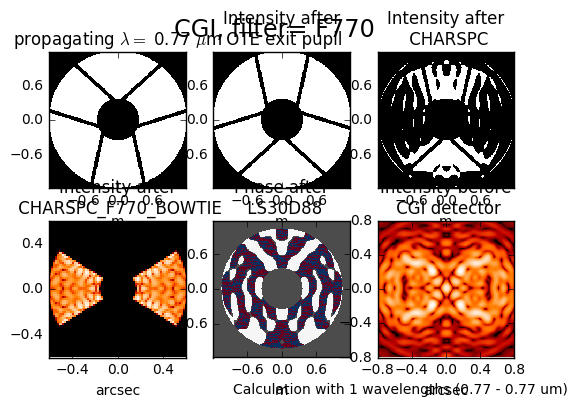

In [6]:
mono_char_spc_psf = char_spc.calc_psf(nlambda=1, fov_arcsec=1.6, display=True)

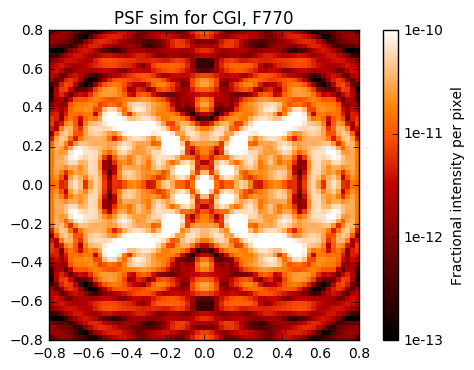

In [7]:
webbpsf.display_psf(mono_char_spc_psf,ext=1,vmin=1e-13, vmax=1e-10)

## Integral field spectrograph PSF with the characterization SPC

In [8]:
webbpsf.setup_logging('ERROR') # Reduce the verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


To approximate the PSF seen by the integral field spectrograph, we can form an array of monochromatic PSFs computed at wavelengths spanning the bandpass:

In [9]:
ifs_spc = wfirst.CGI()
ifs_spc.mode = 'CHARSPC_F890'

filter_fname = ifs_spc._filters[ifs_spc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)
deltalam_ifs = float(filter_hdulist[1].header.get('LAMBDA0'))/70. # Assume spectral resolution R = 70
Nchan = (int(np.floor((wave_end - wave_beg)/deltalam_ifs))//2)*2 + 1 # Number of channels, forced to an odd integer
wavelens = np.linspace(wave_beg, wave_end, Nchan) * 1e-10 # all wavelengths to model, in meters

lamoD_asec = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*ifs_spc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D) in arcsec: %.3f" % lamoD_asec)
print("IFS spectral parameters: %d channels of characteristic spectral width %.2f nm," % (Nchan,deltalam_ifs/10.))
print("ranging from %d nm to %d nm, centered on %d nm" % (wavelens[0]*1e9, wavelens[-1]*1e9, wavelens[Nchan//2]*1e9))
filter_hdulist.close()

System diffraction resolution element scale (lambda_0/D) in arcsec: 0.076
IFS spectral parameters: 13 channels of characteristic spectral width 12.71 nm,
ranging from 809 nm to 970 nm, centered on 890 nm


In [10]:
ifs_spc.options['source_offset_r'] = 0 # arcsec
ifs_spc.options['source_offset_theta'] = 0 # deg w.r.t. North

ifs_psf_onax = []
for w in wavelens:
    psf_onax = ifs_spc.calc_psf(monochromatic=w, fov_arcsec=1.64, oversample=4, display=False)
    ifs_psf_onax.append(psf_onax)

In [11]:
ifs_spc.options['source_offset_r'] = 6*lamoD_asec # 6 lam/D in arcsec
ifs_spc.options['source_offset_theta'] = -90. # deg w.r.t. North
ifs_psf_offax = []
peak_offax = []
for wi, w in enumerate(wavelens):
    psf_offax = ifs_spc.calc_psf(monochromatic=w, fov_arcsec=1.64, oversample=4, display=False)
    ifs_psf_offax.append(psf_offax)
    peak_offax.append(psf_offax[1].data.max())
    # Normalize by the off-axis peak to change to units of contrast
    ifs_psf_onax[wi-1][1].data = ifs_psf_onax[wi-1][1].data/peak_offax[wi-1]

## Plot the polychromatic PSF of the IFS in contrast units. 

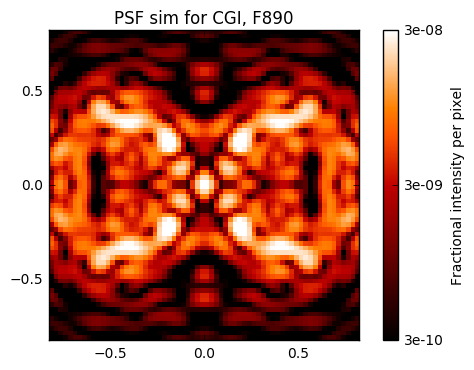

In [12]:
def plt_ifs_psf_onax(wchan):
    webbpsf.display_psf(ifs_psf_onax[wchan-1],ext=1,vmin=3e-10,vmax=3e-8);
ipywidgets.interact(plt_ifs_psf_onax, wchan=(1,Nchan));

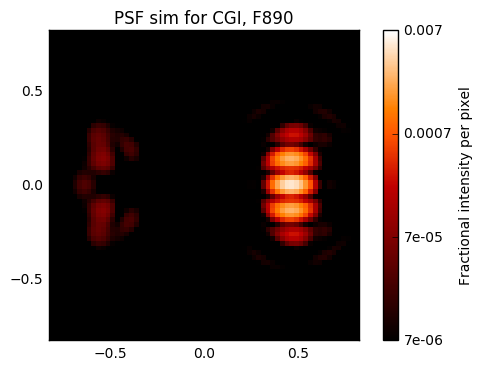

In [13]:
def plt_ifs_psf_offax(wchan):
    webbpsf.display_psf(ifs_psf_offax[wchan-1],ext=1,vmin=7e-6,vmax=7e-3);
ipywidgets.interact(plt_ifs_psf_offax, wchan=(1,len(wavelens)));

# Debris disk mode SPC

In [14]:
diskcg = wfirst.CGI(mode='DISKSPC_F721')
diskcg.options['source_offset_r'] = 0 # arcsec
diskcg.options['source_offset_theta'] = 0 # deg w.r.t. North

In [15]:
diskpsf_onax = diskcg.calc_psf(fov_arcsec=2.2, display=False)

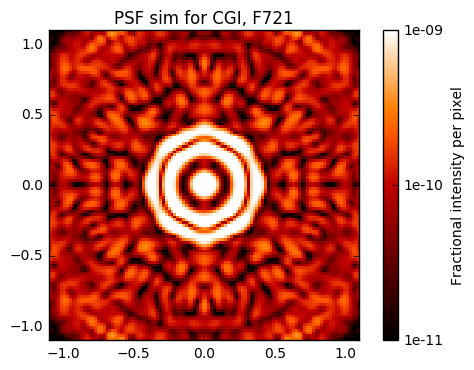

In [16]:
webbpsf.display_psf(diskpsf_onax,ext=1,vmin=1e-11, vmax=1e-9)

## Off-axis PSF

In [17]:
diskcg.options['source_offset_r'] = 0.6 # arcsec
diskcg.options['source_offset_theta'] = -45. # deg w.r.t. North

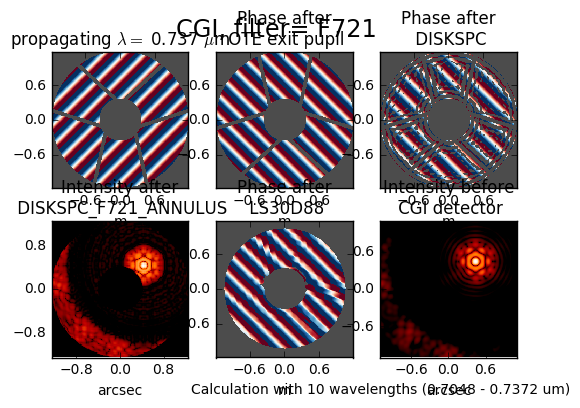

In [18]:
diskpsf_offax = diskcg.calc_psf(fov_arcsec=2.2, display=True)
diskpsf_offax_peak = diskpsf_offax[1].data.max()

In [19]:
# Form a simple bright companion scene by summing the on-axis and off-axis PSF, the latter scaled by 1E-7.
comb_img = (diskpsf_onax[1].data + diskpsf_offax[1].data*1e-7)/diskpsf_offax_peak # Contrast units
comb_hdu = fits.PrimaryHDU(comb_img, header=diskpsf_onax[1].header)
comb_hdulist = fits.HDUList([comb_hdu])

### Plot composite disk SPC PSF (on-axis + off-axis@1E-7 contrast) in units of contrast 

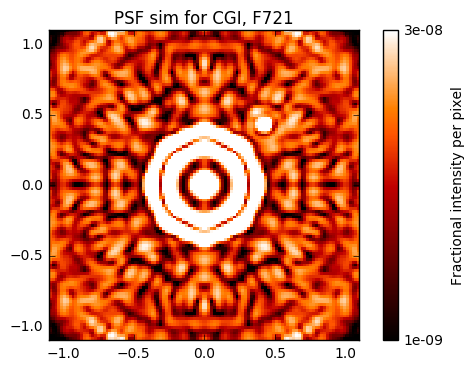

In [20]:
webbpsf.display_psf(comb_hdulist,vmin=1e-9, vmax=3e-8)